In [23]:
# Cell 1: Setup and Imports

#Startup Packages
!pip install uproot
!pip install compress-pickle
!pip install energyflow
!pip install mplhep

#Allow access to drive
import os
import sys
from pathlib import Path
from google.colab import drive

# Mount drive only if not already mounted
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted.")

project_path = '/content/drive/MyDrive/AIpfRICH/ml4patternrec'
project_dir = Path(project_path)
sys.path.append(str(project_dir))

#create dirs for plotting
plot_path = f'{project_path}/plots/QA'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
ddpm_path = f'{project_path}/plots/ddpm_training'
if not os.path.exists(ddpm_path):
    os.makedirs(ddpm_path)
model_dir = f'{project_path}/trained_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

Drive already mounted.


In [24]:
# Cell 2: Core Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

import tensorflow as tf
tf.keras.backend.clear_session()

# Import custom modules
import gradientBoost_hybrid_model as gbhm
from utilityddpm import DDPM_utils
from hybrid_unetdit_tf import HybridUNetDiT_TF, CNNEncoder, EMA
from plotting_utility import PerformancePlotter, evaluate_and_plot_all

print("All imports successful!")

All imports successful!


In [25]:
# Cell 3: Scan ROOT Files
data_dir = f'{project_path}/datafiles/pfRICH-ML-demo/2.reco_files_12GeV'

all_files = []
for f in os.listdir(data_dir):
    if f.endswith('.root'):
        all_files.append(os.path.join(data_dir, f))

# Sort by particle type
electrons = [f for f in all_files if os.path.basename(f).startswith('eminus_')]
pions = [f for f in all_files if os.path.basename(f).startswith('piminus_')]
kaons = [f for f in all_files if os.path.basename(f).startswith('kaonminus_')]
protons = [f for f in all_files if os.path.basename(f).startswith('proton_')]

# Filter out eta=-1.0 files (outside detector acceptance)
def filter_valid_eta(file_list):
    return [f for f in file_list if 'etaneg1_0' not in os.path.basename(f)]

electrons = filter_valid_eta(electrons)
pions = filter_valid_eta(pions)
kaons = filter_valid_eta(kaons)
protons = filter_valid_eta(protons)
# ===============================================

print(f"Total files: {len(all_files)}")
print(f"After filtering η=-1.0: {len(electrons) + len(pions) + len(kaons) + len(protons)}")
print(f"e⁻: {len(electrons)}, π⁻: {len(pions)}, K⁻: {len(kaons)}, proton: {len(protons)}")

Total files: 288
After filtering η=-1.0: 240
e⁻: 60, π⁻: 60, K⁻: 60, proton: 60


In [26]:
# Cell 4: Parameters

MAX_EVENTS_PER_SPECIES = 1000000   # Adjust based on memory
HIST_SHAPE = (64, 64)            # TH2 image size
X_RANGE = (-650, 650)            # X position range [mm]
Y_RANGE = (-650, 650)            # Y position range [mm]
USE_DENOISING = False            # Toggle denoising
CNN_LATENT_DIM = 64              # CNN encoder output dimension
CNN_BATCH_SIZE = 64              # Batch size for CNN inference

# Features for XGBoost
features = ['posX', 'posY', 'posZ', 'momX', 'momY', 'momZ',
            'eta', 'theta', 'phi', 'time', 'cherenkov_angle']
target = 'pdgID'


In [27]:
# Cell 5: Helper Function - Build Per-Event TH2 Images


def build_per_event_histograms(df, hist_shape=HIST_SHAPE,
                                x_range=X_RANGE, y_range=Y_RANGE):
    """
    Build one TH2 histogram per event (beam particle).

    Each event has multiple photon hits (rows with same event ID).
    We aggregate hits per event into a 2D histogram.

    Args:
        df: DataFrame with columns ['event', 'posX', 'posY', ...]
        hist_shape: Output histogram shape (H, W)
        x_range, y_range: Position ranges for binning

    Returns:
        images: np.array of shape (n_events, H, W)
        event_info: DataFrame with one row per event (beam particle info)
    """
    # Group by event ID
    grouped = df.groupby('event')

    images = []
    event_info_list = []

    # Define bin edges
    x_edges = np.linspace(x_range[0], x_range[1], hist_shape[1] + 1)
    y_edges = np.linspace(y_range[0], y_range[1], hist_shape[0] + 1)

    for event_id, group in grouped:
        # Build 2D histogram from photon hits
        hist, _, _ = np.histogram2d(
            group['posX'].values,
            group['posY'].values,
            bins=[x_edges, y_edges]
        )

        # Transpose to match image convention (Y on rows, X on cols)
        hist = hist.T

        # Normalize to [0, 1]
        if hist.max() > 0:
            hist = hist / hist.max()

        images.append(hist)

        # Store beam particle info (first row of group - should be same for all hits)
        first_row = group.iloc[0]
        event_info_list.append({
            'event': event_id,
            'pdgID': first_row['pdgID'],
            'momX': first_row['momX'],
            'momY': first_row['momY'],
            'momZ': first_row['momZ'],
            'pT': first_row['pT'] if 'pT' in first_row else np.sqrt(first_row['momX']**2 + first_row['momY']**2),
            'eta': first_row['eta'],
            'theta': first_row['theta'],
            'phi': first_row['phi'],
            'time': first_row['time'],
            'cherenkov_angle': first_row['cherenkov_angle'],
            'n_hits': len(group)  # Number of photon hits
        })

    images = np.stack(images, axis=0).astype(np.float32)
    event_info = pd.DataFrame(event_info_list)

    print(f"Built {len(images)} per-event TH2 images, shape: {images.shape}")

    return images, event_info

In [28]:
# Cell 6: Load Data

def load_and_build_histograms_by_species(files, species_name, max_events_per_species,
                                          hist_shape=(64,64), x_range=(-650,650), y_range=(-650,650)):
    """Load files for one species and build per-event histograms."""
    if len(files) == 0:
        return np.array([]), pd.DataFrame()

    x_edges = np.linspace(x_range[0], x_range[1], hist_shape[1] + 1)
    y_edges = np.linspace(y_range[0], y_range[1], hist_shape[0] + 1)

    all_images = []
    all_event_info = []
    global_event_id = 0

    for fpath in files:
        with uproot.open(fpath) as f:
            tree = f["Events"]
            df = tree.arrays(library="pd")

        # Group by event within this file
        for event_id, group in df.groupby('event'):
            if len(all_images) >= max_events_per_species:
                break

            # Build 2D histogram
            hist, _, _ = np.histogram2d(
                group['posX'].values,
                group['posY'].values,
                bins=[x_edges, y_edges]
            )
            hist = hist.T  # (Y, X) convention
            if hist.max() > 0:
                hist = hist / hist.max()

            all_images.append(hist)

            # Store event info from first row
            row = group.iloc[0]
            all_event_info.append({
                'event': global_event_id,
                'pdgID': row['pdgID'],
                'momX': row['momX'],
                'momY': row['momY'],
                'momZ': row['momZ'],
                'pT': row.get('pT', np.sqrt(row['momX']**2 + row['momY']**2)),
                'eta': row['eta'],
                'theta': row['theta'],
                'phi': row['phi'],
                'time': row['time'],
                'cherenkov_angle': row['cherenkov_angle'],
                'n_hits': len(group)
            })
            global_event_id += 1

        if len(all_images) >= max_events_per_species:
            break

    if len(all_images) == 0:
        return np.array([]), pd.DataFrame()

    print(f"  {species_name}: {len(all_images)} events loaded")
    return np.stack(all_images, axis=0).astype(np.float32), pd.DataFrame(all_event_info)

print("\n===== LOADING DATA AND BUILDING HISTOGRAMS BY SPECIES =====")

# Process each species separately
MAX_PER_SPECIES = 1000000  # Adjust as needed

imgs_e, df_e = load_and_build_histograms_by_species(electrons, "electrons", MAX_PER_SPECIES, HIST_SHAPE)
imgs_pi, df_pi = load_and_build_histograms_by_species(pions, "pions", MAX_PER_SPECIES, HIST_SHAPE)
imgs_k, df_k = load_and_build_histograms_by_species(kaons, "kaons", MAX_PER_SPECIES, HIST_SHAPE)
imgs_p, df_p = load_and_build_histograms_by_species(protons, "protons", MAX_PER_SPECIES, HIST_SHAPE)

# Combine all
imgs_all = np.concatenate([imgs_e, imgs_pi, imgs_k, imgs_p], axis=0)
event_df = pd.concat([df_e, df_pi, df_k, df_p], ignore_index=True)

# Reset event IDs to be sequential
event_df['event'] = np.arange(len(event_df))

print(f"\nTotal images: {imgs_all.shape}")
print(f"Total events: {len(event_df)}")
print(f"\npdgID distribution:")
print(event_df['pdgID'].value_counts())


===== LOADING DATA AND BUILDING HISTOGRAMS BY SPECIES =====
  electrons: 581436 events loaded
  pions: 579626 events loaded
  kaons: 568105 events loaded
  protons: 554682 events loaded

Total images: (2283849, 64, 64)
Total events: 2283849

pdgID distribution:
pdgID
 11.0      625812
-211.0     568140
 2212.0    538101
-321.0     528816
 13.0       17162
 211.0       4576
-11.0        1105
 321.0         81
-13.0          39
 3112.0        11
 3222.0         6
Name: count, dtype: int64


In [29]:
# CELL 7: Build CNN Encoder for Feature Extraction

print("\n===== BUILDING CNN ENCODER =====")

def build_cnn_encoder(input_shape=(64, 64, 1), latent_dim=64):
    """Build a simple CNN encoder for extracting image embeddings."""
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(latent_dim, activation=None),
        tf.keras.layers.LayerNormalization()
    ], name='cnn_encoder')

    return model

cnn_encoder = build_cnn_encoder(
    input_shape=(HIST_SHAPE[0], HIST_SHAPE[1], 1),
    latent_dim=CNN_LATENT_DIM
)
cnn_encoder.summary()



===== BUILDING CNN ENCODER =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "cnn_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,056 (394.75 KB)

 Trainable params: 101,056 (394.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Cell 8: Extract CNN Embeddings (Pattern Recognition Features)

print("\n===== EXTRACTING CNN EMBEDDINGS =====")

# Add channel dimension for CNN
imgs_with_channel = imgs_all[..., np.newaxis].astype(np.float32)

# Extract embeddings in batches
Z_list = []
for i in range(0, len(imgs_with_channel), CNN_BATCH_SIZE):
    batch = imgs_with_channel[i:i+CNN_BATCH_SIZE]
    z = cnn_encoder.predict(batch, verbose=0)
    Z_list.append(z)

Z_img = np.concatenate(Z_list, axis=0)
print(f"CNN embeddings shape: {Z_img.shape}")


===== EXTRACTING CNN EMBEDDINGS =====
CNN embeddings shape: (2283849, 64)


In [31]:
# Cell 9: Prepare Combined Features for XGBoost

print("\n===== PREPARING COMBINED FEATURES =====")

# Beam particle features from event_df
beam_features = ['pT', 'eta', 'theta', 'phi', 'time', 'cherenkov_angle', 'n_hits']

# Calculate momentum magnitude
event_df['p_mag'] = np.sqrt(
    event_df['momX']**2 +
    event_df['momY']**2 +
    event_df['momZ']**2
)
beam_features.append('p_mag')

X_beam = event_df[beam_features].values

# Combine beam features + CNN embeddings
X_combined = np.concatenate([X_beam, Z_img], axis=1)

# Labels
y_raw = event_df[target].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw).astype(int)

print(f"Combined features shape: {X_combined.shape}")
print(f"Labels shape: {y_encoded.shape}")
print(f"Class mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")



===== PREPARING COMBINED FEATURES =====
Combined features shape: (2283849, 72)
Labels shape: (2283849,)
Class mapping: {-321.0: 0, -211.0: 1, -13.0: 2, -11.0: 3, 11.0: 4, 13.0: 5, 211.0: 6, 321.0: 7, 2212.0: 8, 3112.0: 9, 3222.0: 10}


In [32]:
# Cell 10: Train/Test Split

print("\n===== TRAIN/TEST SPLIT =====")

# Check class distribution
unique, counts = np.unique(y_encoded, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    pdg = le.inverse_transform([u])[0]
    print(f"  Class {u} (pdgID={pdg}): {c} samples")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")


===== TRAIN/TEST SPLIT =====
Class distribution:
  Class 0 (pdgID=-321.0): 528816 samples
  Class 1 (pdgID=-211.0): 568140 samples
  Class 2 (pdgID=-13.0): 39 samples
  Class 3 (pdgID=-11.0): 1105 samples
  Class 4 (pdgID=11.0): 625812 samples
  Class 5 (pdgID=13.0): 17162 samples
  Class 6 (pdgID=211.0): 4576 samples
  Class 7 (pdgID=321.0): 81 samples
  Class 8 (pdgID=2212.0): 538101 samples
  Class 9 (pdgID=3112.0): 11 samples
  Class 10 (pdgID=3222.0): 6 samples

Train size: 1712886, Test size: 570963


In [33]:
# Cell 11: Train XGBoost Classifier

print("\n===== TRAINING XGBOOST =====")

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': len(le.classes_),
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'mlogloss'
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    verbose_eval=50
)



===== TRAINING XGBOOST =====
[0]	train-mlogloss:1.88448	test-mlogloss:1.88458
[50]	train-mlogloss:0.14817	test-mlogloss:0.14965
[100]	train-mlogloss:0.11189	test-mlogloss:0.11497
[150]	train-mlogloss:0.10501	test-mlogloss:0.11038
[200]	train-mlogloss:0.10087	test-mlogloss:0.10889
[250]	train-mlogloss:0.09774	test-mlogloss:0.10826
[299]	train-mlogloss:0.09507	test-mlogloss:0.10795


In [34]:
# Cell 12: Evaluate XGBoost Performance

print("\n===== XGBOOST EVALUATION =====")

# Predictions
y_pred = xgb_model.predict(dtest).astype(int)
y_pred_train = xgb_model.predict(dtrain).astype(int)

# Accuracy
acc_test = accuracy_score(y_test, y_pred)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test Accuracy:  {acc_test:.4f}")

# Classification report - use only labels present in the data
labels_present = np.unique(np.concatenate([y_test, y_pred]))
class_names_present = [str(le.inverse_transform([l])[0]) for l in labels_present]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels_present, target_names=class_names_present))


===== XGBOOST EVALUATION =====
Train Accuracy: 0.9591
Test Accuracy:  0.9501

Classification Report:
              precision    recall  f1-score   support

      -321.0       0.94      0.97      0.95    132204
      -211.0       0.91      0.93      0.92    142035
       -13.0       0.00      0.00      0.00        10
       -11.0       0.53      0.20      0.29       276
        11.0       0.97      0.93      0.95    156453
        13.0       0.83      0.88      0.85      4291
       211.0       0.42      0.23      0.30      1144
       321.0       0.00      0.00      0.00        20
      2212.0       0.99      0.98      0.99    134525
      3112.0       0.00      0.00      0.00         3
      3222.0       0.00      0.00      0.00         2

    accuracy                           0.95    570963
   macro avg       0.51      0.47      0.48    570963
weighted avg       0.95      0.95      0.95    570963



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



===== CONFUSION MATRIX =====


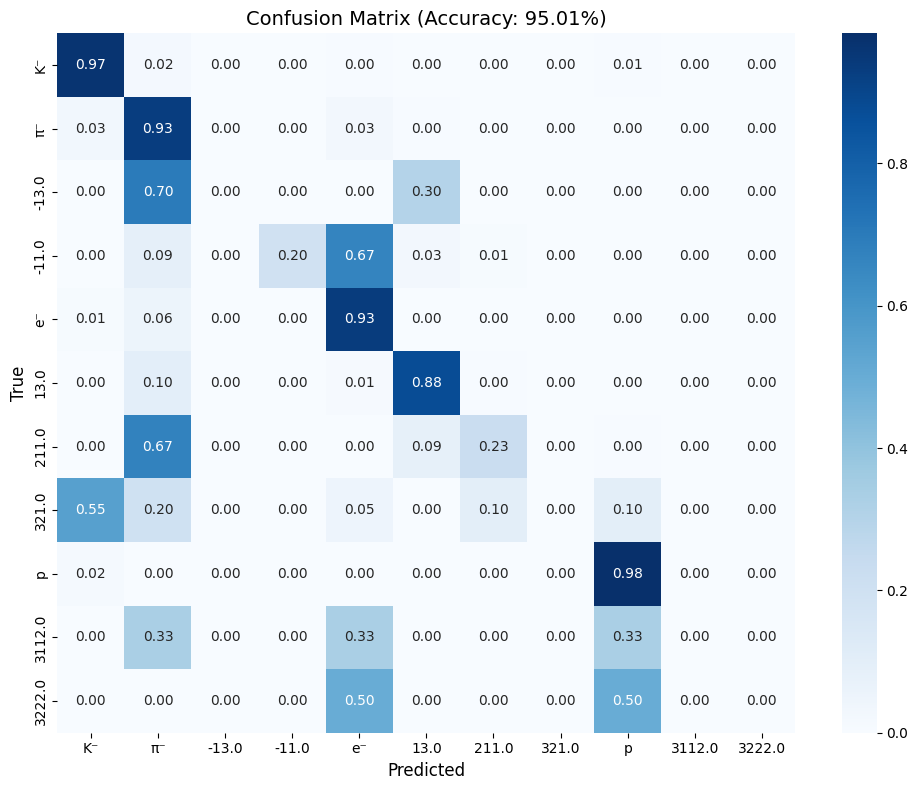

In [35]:
# Cell 13: Confusion Matrix

print("\n===== CONFUSION MATRIX =====")

species_names = {11: 'e⁻', -211: 'π⁻', -321: 'K⁻', 2212: 'p'}
display_names = [species_names.get(c, str(c)) for c in le.classes_]

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=display_names, yticklabels=display_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix (Accuracy: {acc_test:.2%})', fontsize=14)
plt.tight_layout()
plt.savefig(f'{plot_path}/confusion_matrix_hybrid.png', dpi=150)
plt.show()


===== PID EFFICIENCY VS MOMENTUM =====


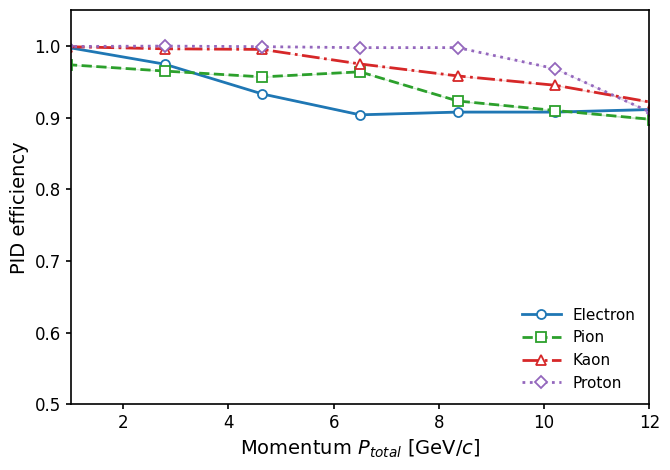

In [36]:
# Cell 14: PID Efficiency vs Momentum
# PRL-style, with color + error bands


print("\n===== PID EFFICIENCY VS MOMENTUM =====")

# -----------------------
# Predictions
# -----------------------
dall = xgb.DMatrix(X_combined)
pred_all = xgb_model.predict(dall).astype(int)
pred_all_pdg = le.inverse_transform(pred_all)
event_df['pred_pdgID'] = pred_all_pdg

# -----------------------
# Momentum binning
# -----------------------
p_bins = np.linspace(0.0, 13.0, 8)
bin_centers = 0.5 * (p_bins[1:] + p_bins[:-1])

species = {
    'Electron': 11,
    'Pion':    -211,
    'Kaon':    -321,
    'Proton':  2212
}

efficiency = {k: [] for k in species}
efficiency_err = {k: [] for k in species}

# -----------------------
# Efficiency + binomial error
# -----------------------
for i in range(len(p_bins) - 1):
    p_low, p_high = p_bins[i], p_bins[i + 1]

    for name, pdg in species.items():
        mask = (
            (event_df['p_mag'] >= p_low) &
            (event_df['p_mag'] <  p_high) &
            (event_df['pdgID'] == pdg)
        )

        N = int(mask.sum())

        if N > 0:
            n_correct = int((event_df.loc[mask, 'pred_pdgID'] == pdg).sum())
            eff = n_correct / N
            err = np.sqrt(eff * (1.0 - eff) / N)

            efficiency[name].append(eff)
            efficiency_err[name].append(err)
        else:
            efficiency[name].append(np.nan)
            efficiency_err[name].append(np.nan)

# -----------------------
# Plot (PRL-style)
# -----------------------
plt.figure(figsize=(6.8, 4.8))

markers = {'Electron': 'o', 'Pion': 's', 'Kaon': '^', 'Proton': 'D'}
linestyles = {'Electron': '-', 'Pion': '--', 'Kaon': '-.', 'Proton': ':'}
colors = {
    'Electron': '#1f77b4',  # blue
    'Pion':     '#2ca02c',  # green
    'Kaon':     '#d62728',  # red
    'Proton':   '#9467bd'   # purple
}

for name in species:
    eff = np.asarray(efficiency[name], dtype=float)
    err = np.asarray(efficiency_err[name], dtype=float)

    valid = np.isfinite(eff) & np.isfinite(err)

    if not np.any(valid):
        continue

    # Central values
    plt.plot(
        bin_centers[valid],
        eff[valid],
        label=name,
        marker=markers[name],
        linestyle=linestyles[name],
        color=colors[name],
        linewidth=2.0,
        markersize=6.5,
        markerfacecolor='white',
        markeredgewidth=1.3
    )

    # Error bands (clipped to physical range)
    lower = np.clip(eff - err, 0.0, 1.0)
    upper = np.clip(eff + err, 0.0, 1.0)

    plt.fill_between(
        bin_centers[valid],
        lower[valid],
        upper[valid],
        color=colors[name],
        alpha=0.25,
        linewidth=0
    )

# -----------------------
# Axes & cosmetics
# -----------------------
plt.xlabel(r'Momentum $P_{total}$ [GeV/$c$]', fontsize=14)
plt.ylabel('PID efficiency', fontsize=14)

plt.xlim(1.0, 12.0)
plt.ylim(0.5, 1.05)

plt.tick_params(axis='both', which='major', labelsize=12, width=1.2)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)

plt.legend(
    frameon=False,
    fontsize=11,
    loc='lower right',
    handlelength=2.5
)

plt.tight_layout()
plt.savefig(
    f'{plot_path}/pid_efficiency_vs_momentum_prl_color_bands.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()





===== FEATURE IMPORTANCE =====


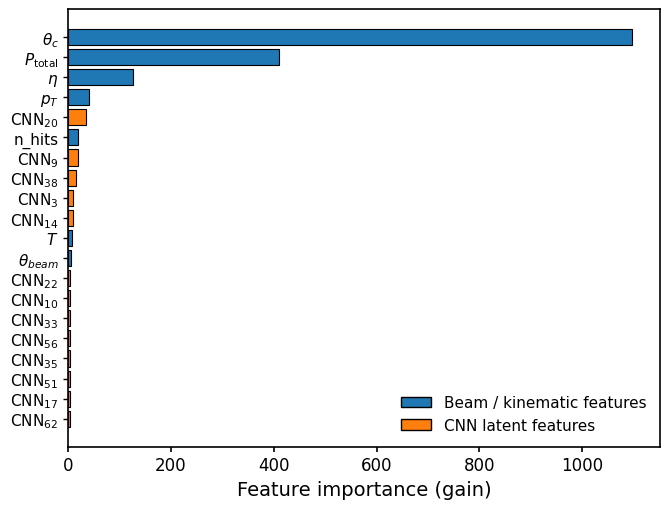

In [37]:
# Cell 15: Feature Importance Analysis
# PRL-style, with color (display-name only)

print("\n===== FEATURE IMPORTANCE =====")

# -----------------------
# Get feature importance
# -----------------------
importance = xgb_model.get_score(importance_type='gain')

# Feature names (MODEL / INTERNAL)
feature_names = beam_features + [f'cnn_{i}' for i in range(CNN_LATENT_DIM)]

# Map XGBoost feature indices to names
importance_dict = {}
for k, v in importance.items():
    idx = int(k.replace('f', ''))
    if idx < len(feature_names):
        importance_dict[feature_names[idx]] = v

# Sort top features
sorted_importance = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)[:20]

names, values = zip(*sorted_importance)

# =================================================
# DISPLAY LABELS (EDIT THIS FREELY — GRAPH ONLY)
# =================================================
DISPLAY_LABELS = {
    # Kinematics
    'p_mag': r'$P_{\mathrm{total}}$',
    'pT': r'$p_{T}$',
    'eta': r'$\eta$',
    'phi': r'$\phi$',
    'theta': r'$\theta_{beam}$',
    # PID / RICH
    'cherenkov_angle': r'$\theta_{c}$',
    'npe': r'$N_{\mathrm{pe}}$',

    # Timing / geometry
    'time': r'$T$',
    'path_length': r'$L_{\mathrm{track}}$',

    # CNN latents (optional override)
    # 'cnn_0': r'CNN$_{0}$',
}

# Auto-label CNN latents if not manually overridden
for i in range(CNN_LATENT_DIM):
    DISPLAY_LABELS.setdefault(
        f'cnn_{i}',
        rf'CNN$_{{{i}}}$'
    )

# Build display names (NO effect on model)
display_names = [
    DISPLAY_LABELS.get(name, name) for name in names
]

# -----------------------
# Color coding
# -----------------------
colors = []
for name in names:
    if name in beam_features:
        colors.append('#1f77b4')   # beam / kinematic
    else:
        colors.append('#ff7f0e')   # CNN latent

# =======================
# Plot (PRL-style)
# =======================

plt.figure(figsize=(6.8, 5.2))

y_pos = np.arange(len(names))

plt.barh(
    y_pos,
    values,
    color=colors,
    edgecolor='black',
    linewidth=0.8
)

plt.yticks(y_pos, display_names, fontsize=11)
plt.xlabel('Feature importance (gain)', fontsize=14)

plt.gca().invert_yaxis()

plt.tick_params(axis='x', labelsize=12, width=1.2)
plt.tick_params(axis='y', width=1.0)

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black',
          label='Beam / kinematic features'),
    Patch(facecolor='#ff7f0e', edgecolor='black',
          label='CNN latent features')
]

plt.legend(
    handles=legend_elements,
    frameon=False,
    fontsize=11,
    loc='lower right'
)

plt.tight_layout()
plt.savefig(
    f'{plot_path}/feature_importance_prl_color.pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()



In [38]:
# Cell 16: Save Model and Results

print("\n===== SAVING MODEL =====")

# Save XGBoost model
xgb_model.save_model(f'{model_dir}/hybrid_xgb_model.json')

# Save label encoder
import joblib
joblib.dump(le, f'{model_dir}/label_encoder.pkl')

# Save CNN encoder weights
cnn_encoder.save_weights(f'{model_dir}/cnn_encoder.weights.h5')

print(f"Models saved to {model_dir}")


===== SAVING MODEL =====
Models saved to /content/drive/MyDrive/AIpfRICH/ml4patternrec/trained_models


In [39]:
# Cell 17: Summary Statistics

print("\n" + "="*60)
print("HYBRID PID PIPELINE - SUMMARY")
print("="*60)
print(f"Total events processed: {len(event_df)}")
print(f"Image shape: {HIST_SHAPE}")
print(f"CNN embedding dim: {CNN_LATENT_DIM}")
print(f"Combined features: {X_combined.shape[1]}")
print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
print(f"\nFinal Test Accuracy: {acc_test:.4f}")
print("="*60)

# Per-species efficiency summary
print("\nPer-Species Efficiency Summary:")
for name, pdg in species.items():
    mask = event_df['pdgID'] == pdg
    if mask.sum() > 0:
        eff = (event_df.loc[mask, 'pred_pdgID'] == pdg).mean()
        print(f"  {name:10s}: {eff:.4f}")




HYBRID PID PIPELINE - SUMMARY
Total events processed: 2283849
Image shape: (64, 64)
CNN embedding dim: 64
Combined features: 72
Train/Test split: 1712886/570963

Final Test Accuracy: 0.9501

Per-Species Efficiency Summary:
  Electron  : 0.9378
  Pion      : 0.9427
  Kaon      : 0.9704
  Proton    : 0.9851



===== π/e and π/K SEPARATION (nσ) VS MOMENTUM =====


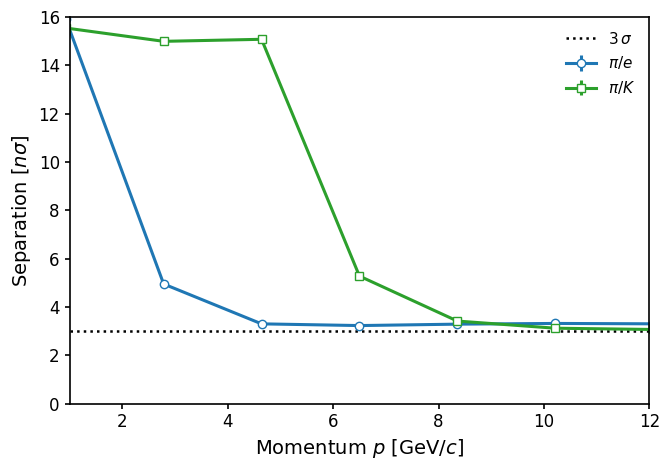

In [40]:
# ============================================================
# Cell π/e and π/K separation in nσ vs momentum (binary models)
# PRL-clean: train/test split, effective nσ
# ============================================================

print("\n===== π/e and π/K SEPARATION (nσ) VS MOMENTUM =====")

from sklearn.model_selection import train_test_split

# -----------------------
# Common momentum binning
# -----------------------
p_bins = np.linspace(0.0, 13.0, 8)
bin_centers = 0.5 * (p_bins[1:] + p_bins[:-1])

# ============================================================
# π / e
# ============================================================
mask_pe = event_df["pdgID"].isin([-211, 11])
X_pe = X_combined[mask_pe]
df_pe = event_df.loc[mask_pe].copy()
y_pe = np.where(df_pe["pdgID"].values == 11, 1, 0)

X_tr, X_te, y_tr, y_te, df_tr, df_te = train_test_split(
    X_pe, y_pe, df_pe,
    test_size=0.30,
    random_state=42,
    stratify=y_pe
)

dtrain = xgb.DMatrix(X_tr, label=y_tr)
xgb_pe = xgb.train(
    {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "max_depth": 6,
        "eta": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
    },
    dtrain,
    num_boost_round=200
)

df_te = df_te.copy()
df_te["score"] = xgb_pe.predict(xgb.DMatrix(X_te))

n_sigma_pe, n_sigma_pe_err = [], []

for i in range(len(p_bins) - 1):
    df_bin = df_te[
        (df_te["p_mag"] >= p_bins[i]) &
        (df_te["p_mag"] <  p_bins[i + 1])
    ]

    df_pi = df_bin[df_bin["pdgID"] == -211]
    df_e  = df_bin[df_bin["pdgID"] == 11]

    if len(df_pi) < 100 or len(df_e) < 100:
        n_sigma_pe.append(np.nan)
        n_sigma_pe_err.append(np.nan)
        continue

    mu_pi, mu_e = df_pi["score"].mean(), df_e["score"].mean()
    sig_pi, sig_e = df_pi["score"].std(ddof=1), df_e["score"].std(ddof=1)

    ns = np.abs(mu_e - mu_pi) / np.sqrt(sig_pi**2 + sig_e**2)
    err = ns * np.sqrt(
        (sig_pi**2 / (2 * len(df_pi)) + sig_e**2 / (2 * len(df_e)))
        / (sig_pi**2 + sig_e**2)
    )

    n_sigma_pe.append(ns)
    n_sigma_pe_err.append(err)

# ============================================================
# π / K
# ============================================================
mask_pk = event_df["pdgID"].isin([-211, -321])
X_pk = X_combined[mask_pk]
df_pk = event_df.loc[mask_pk].copy()
y_pk = np.where(df_pk["pdgID"].values == -321, 1, 0)

X_tr, X_te, y_tr, y_te, df_tr, df_te = train_test_split(
    X_pk, y_pk, df_pk,
    test_size=0.30,
    random_state=42,
    stratify=y_pk
)

dtrain = xgb.DMatrix(X_tr, label=y_tr)
xgb_pk = xgb.train(
    {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "max_depth": 6,
        "eta": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
    },
    dtrain,
    num_boost_round=200
)

df_te = df_te.copy()
df_te["score"] = xgb_pk.predict(xgb.DMatrix(X_te))

n_sigma_pk, n_sigma_pk_err = [], []

for i in range(len(p_bins) - 1):
    df_bin = df_te[
        (df_te["p_mag"] >= p_bins[i]) &
        (df_te["p_mag"] <  p_bins[i + 1])
    ]

    df_pi = df_bin[df_bin["pdgID"] == -211]
    df_k  = df_bin[df_bin["pdgID"] == -321]

    if len(df_pi) < 100 or len(df_k) < 100:
        n_sigma_pk.append(np.nan)
        n_sigma_pk_err.append(np.nan)
        continue

    mu_pi, mu_k = df_pi["score"].mean(), df_k["score"].mean()
    sig_pi, sig_k = df_pi["score"].std(ddof=1), df_k["score"].std(ddof=1)

    ns = np.abs(mu_k - mu_pi) / np.sqrt(sig_pi**2 + sig_k**2)
    err = ns * np.sqrt(
        (sig_pi**2 / (2 * len(df_pi)) + sig_k**2 / (2 * len(df_k)))
        / (sig_pi**2 + sig_k**2)
    )

    n_sigma_pk.append(ns)
    n_sigma_pk_err.append(err)

# ============================================================
# Plot (PRL-style)
# ============================================================
plt.figure(figsize=(6.8, 4.8))

plt.errorbar(
    bin_centers, n_sigma_pe, yerr=n_sigma_pe_err,
    marker="o", linestyle="-", linewidth=2.2,
    color="#1f77b4", markerfacecolor="white",
    label=r"$\pi/e$"
)

plt.errorbar(
    bin_centers, n_sigma_pk, yerr=n_sigma_pk_err,
    marker="s", linestyle="-", linewidth=2.2,
    color="#2ca02c", markerfacecolor="white",
    label=r"$\pi/K$"
)

plt.axhline(3.0, linestyle=":", color="black", linewidth=1.8, label=r"$3\,\sigma$")

plt.xlabel(r"Momentum $p$ [GeV/$c$]", fontsize=14)
plt.ylabel(r"Separation [$n\sigma$]", fontsize=14)

plt.xlim(1.0, 12.0)
plt.ylim(0.0, 16.0)

plt.tick_params(axis="both", labelsize=12, width=1.2)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)

plt.legend(frameon=False, fontsize=11)
plt.tight_layout()
plt.savefig(f"{plot_path}/pi_e_pi_k_nsigma_vs_momentum.pdf", dpi=300)
plt.show()




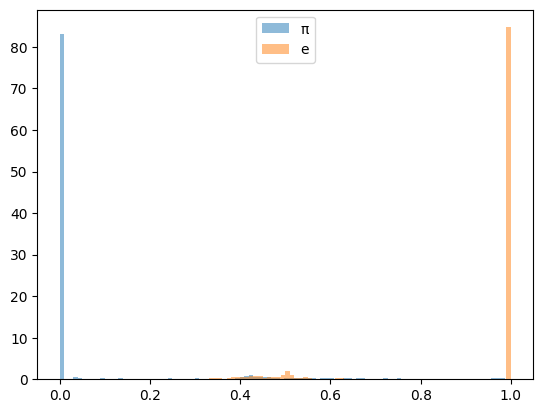

In [41]:
plt.hist(df_pi["score"], bins=100, density=True, alpha=0.5, label="π")
plt.hist(df_e["score"],  bins=100, density=True, alpha=0.5, label="e")
plt.legend()
plt.show()


In [42]:
from scipy.spatial.distance import jensenshannon

# normalized histograms
hist_pi, bins = np.histogram(df_pi["score"], bins=100, density=True)
hist_e,  _    = np.histogram(df_e["score"],  bins=bins, density=True)

# numerical safety / avoid division by zero
hist_pi += 1e-12
hist_e  += 1e-12

# Jensen-Shannon distance
js = jensenshannon(hist_pi, hist_e)

print("Jensen–Shannon distance =", js)


Jensen–Shannon distance = 0.7218861913223097



===== PID EFFICIENCY MAP: p vs eta (ALL SPECIES) =====


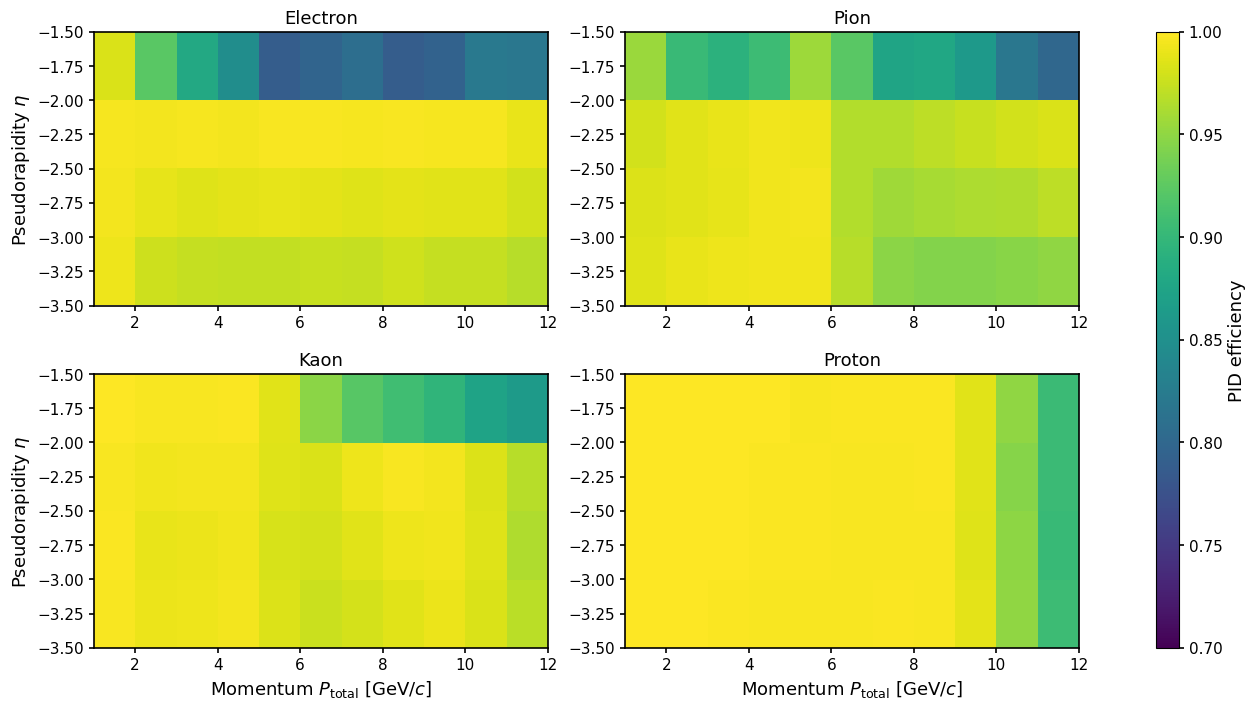

In [43]:
# ============================================================
# PID efficiency map ε(p,η) — clean layout
# Same method as kaon-only, repeated for e, π, K, p
# ============================================================

print("\n===== PID EFFICIENCY MAP: p vs eta (ALL SPECIES) =====")

species = {
    'Electron': 11,
    'Pion':    -211,
    'Kaon':    -321,
    'Proton':  2212
}

# Binning (same philosophy as kaon-only)
p_bins   = np.linspace(1.0, 12.0, 12)
eta_bins = np.linspace(-3.5, -1.5, 5)

# ------------------------------------------------------------
# Figure layout: 2x2 plots + 1 colorbar column
# ------------------------------------------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.25, hspace=0.25)

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]
cax = fig.add_subplot(gs[:, 2])  # colorbar axis (external)

vmin, vmax = 0.7, 1.0
im = None

for ax, (name, pdg_target) in zip(axes, species.items()):

    df = event_df[event_df['pdgID'] == pdg_target].copy()
    eff_map = np.full((len(eta_bins) - 1, len(p_bins) - 1), np.nan)

    for i in range(len(eta_bins) - 1):
        for j in range(len(p_bins) - 1):

            mask = (
                (df['eta']   >= eta_bins[i])   & (df['eta']   < eta_bins[i + 1]) &
                (df['p_mag'] >= p_bins[j])     & (df['p_mag'] < p_bins[j + 1])
            )

            if mask.sum() < 50:
                continue

            eff_map[i, j] = (df.loc[mask, 'pred_pdgID'] == pdg_target).mean()

    im = ax.imshow(
        eff_map,
        origin='lower',
        aspect='auto',
        extent=[p_bins[0], p_bins[-1], eta_bins[0], eta_bins[-1]],
        vmin=vmin,
        vmax=vmax,
        cmap='viridis'
    )

    ax.set_title(name, fontsize=13)
    ax.tick_params(axis='both', labelsize=11, width=1.2)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

# Axis labels
axes[2].set_xlabel(r"Momentum $P_{\mathrm{total}}$ [GeV/$c$]", fontsize=13)
axes[3].set_xlabel(r"Momentum $P_{\mathrm{total}}$ [GeV/$c$]", fontsize=13)
axes[0].set_ylabel(r"Pseudorapidity $\eta$", fontsize=13)
axes[2].set_ylabel(r"Pseudorapidity $\eta$", fontsize=13)

# ------------------------------------------------------------
# External colorbar (legend)
# ------------------------------------------------------------
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("PID efficiency", fontsize=13)
cbar.ax.tick_params(labelsize=11, width=1.2)

plt.savefig(
    f"{plot_path}/pid_efficiency_map_all_species_p_eta.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()





===== MIS-ID PROBABILITIES VS MOMENTUM (π, K, e) =====
  Processing pi truth


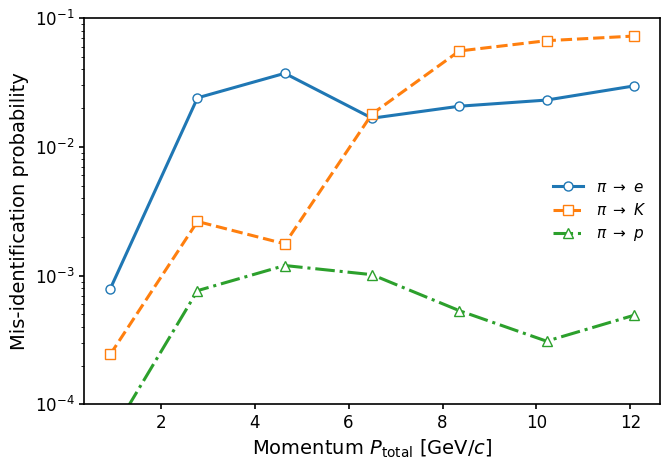

  Processing K truth


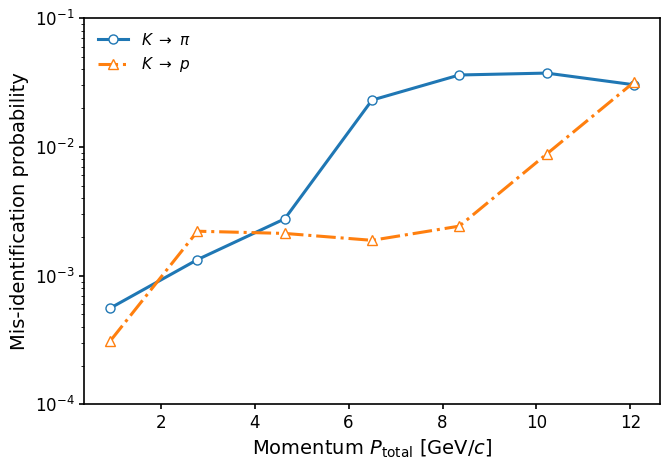

  Processing e truth


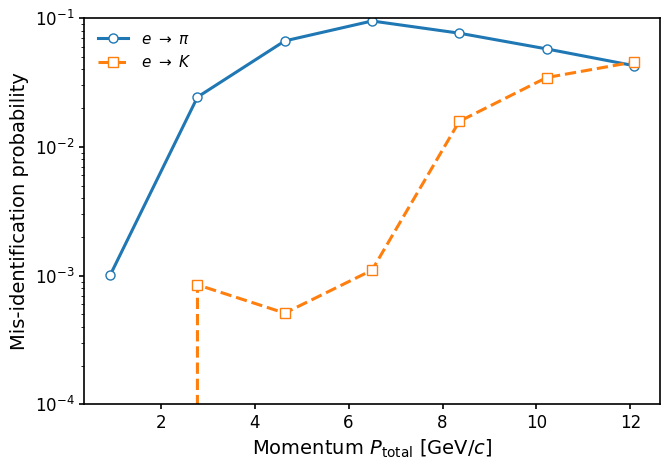

In [44]:
# Mis-identification probabilities vs momentum
# One canvas per truth particle (π, K, e)
# LaTeX legend fixed (pi -> \pi, etc.)

print("\n===== MIS-ID PROBABILITIES VS MOMENTUM (π, K, e) =====")

truth_configs = {
    -211: {  # pion truth
        'label_tex': r'$\pi$',
        'label_txt': 'pi',
        'mis_targets': {'e': 11, 'K': -321, 'p': 2212}
    },
    -321: {  # kaon truth
        'label_tex': r'$K$',
        'label_txt': 'K',
        'mis_targets': {'pi': -211, 'p': 2212}
    },
     11: {   # electron truth
        'label_tex': r'$e$',
        'label_txt': 'e',
        'mis_targets': {'pi': -211, 'K': -321}
    }
}

# Display mapping for legend (LaTeX)
disp = {
    'e':  r'$e$',
    'pi': r'$\pi$',
    'K':  r'$K$',
    'p':  r'$p$'
}

p_bins = np.linspace(0, 13.0, 8)
bin_centers = 0.5 * (p_bins[1:] + p_bins[:-1])

styles = {
    'e':  ('o', '-'),
    'K':  ('s', '--'),
    'p':  ('^', '-.'),
    'pi': ('o', '-')
}

for true_pdg, cfg in truth_configs.items():

    print(f"  Processing {cfg['label_txt']} truth")

    df = event_df[event_df['pdgID'] == true_pdg].copy()
    mis_prob = {k: [] for k in cfg['mis_targets']}

    for j in range(len(p_bins) - 1):
        p_low, p_high = p_bins[j], p_bins[j + 1]

        mask = (
            (df['p_mag'] >= p_low) &
            (df['p_mag'] <  p_high)
        )

        if mask.sum() < 50:
            for k in mis_prob:
                mis_prob[k].append(np.nan)
            continue

        for name, pdg_mis in cfg['mis_targets'].items():
            mis_prob[name].append(
                (df.loc[mask, 'pred_pdgID'] == pdg_mis).mean()
            )

    plt.figure(figsize=(6.8, 4.8))

    for name, values in mis_prob.items():
        marker, ls = styles[name]
        plt.plot(
            bin_centers,
            values,
            marker=marker,
            linestyle=ls,
            linewidth=2.2,
            markersize=6.5,
            markerfacecolor='white',
            label=rf'{cfg["label_tex"]} $\to$ {disp[name]}'
        )

    plt.xlabel(r"Momentum $P_{\mathrm{total}}$ [GeV/$c$]", fontsize=14)
    plt.ylabel("Mis-identification probability", fontsize=14)

    plt.yscale('log')
    plt.ylim(1e-4, 1e-1)

    plt.tick_params(axis='both', which='major', labelsize=12, width=1.2)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.2)

    plt.legend(frameon=False, fontsize=11)
    plt.tight_layout()

    plt.savefig(
        f"{plot_path}/misid_{cfg['label_txt']}_vs_momentum.pdf",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()



